In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pandas.api.types import is_numeric_dtype

In [2]:
raw_data = pd.read_csv('Data/kc_house_data.csv')
raw_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [ ]:
# from geopy.geocoders import Nominatim
# def get_city(lat, long):
#     geolocator = Nominatim(user_agent="geoapiExercises")
#     location = geolocator.reverse(lat+","+long)
#     address = location.raw['address']
#     city = address.get('city', '')
#     town = address.get('town', '')
#     if city == '':
#         return town
#     else:
#         return city

# get_city(str(47.5427), str(-122.288))

# for i in range(10):
#     print(get_city(str(raw_data.loc[i, 'lat']), str(raw_data.loc[i, 'long'])))

# Create city column
# raw_data['city'] = raw_data.apply(lambda row: get_city(str(row.lat), str(row.long)), axis=1)

In [3]:
# Data prep and cleaning
clean_data = raw_data.copy()

# Change to datetime and add month column
clean_data['date'] = pd.to_datetime(clean_data['date'])
clean_data['month'] = pd.DatetimeIndex(clean_data['date']).month

# Change waterfront missing value to No
clean_data.loc[raw_data.waterfront.isnull(), 'waterfront'] = 'NO'
clean_data['waterfront'] = clean_data['waterfront'].apply(lambda x: 0 if x == 'NO' else 1)

# Change view missing value to None
clean_data.loc[raw_data.view.isnull(), 'view'] = "NONE"
view_dict = {'NONE':0, 'FAIR':1, 'AVERAGE':2, 'GOOD':3, 'EXCELLENT':4}
clean_data['view'].replace(view_dict, inplace=True)

# Change condition to numerical value
cond_dict = {'Poor':0, 'Fair':1, 'Average':2, 'Good':3, 'Very Good':4}
clean_data['condition'].replace(cond_dict, inplace=True)

# Change grade to numerical value
clean_data['grade'] = clean_data['grade'].map(lambda x: int(x.split(' ')[0]))

# Add has_basement column
clean_data['sqft_basement'] = clean_data['sqft_basement'].replace('?', '0').astype('float')
clean_data['basement'] = clean_data['sqft_basement'].apply(lambda x: 0 if x == 0 else 1)

# Change some yr_renovated missing value to 0 and add renovated column
clean_data.loc[raw_data.yr_renovated.isnull(), 'yr_renovated'] = 0
clean_data['renovated'] = clean_data['yr_renovated'].apply(lambda x: 0 if x == 0 else 1)

# Add house_age column
clean_data['age'] = clean_data['date'].dt.year - clean_data['yr_built']

In [4]:
clean_data['month'] = clean_data['month'].replace(12, 0)
#clean_data['season']

bins = [0, 3, 6, 9, 11]
clean_data['season'] = pd.cut(clean_data['month'], bins, include_lowest = True, labels = ['Winter', 'Spring', 'Summer', 'Fall'])

clean_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,month,basement,renovated,age,season
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,98178,47.5112,-122.257,1340,5650,10,0,0,59,Fall
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,98125,47.7210,-122.319,1690,7639,0,1,1,63,Winter
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,98028,47.7379,-122.233,2720,8062,2,0,0,82,Winter
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,98136,47.5208,-122.393,1360,5000,0,1,0,49,Winter
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,98074,47.6168,-122.045,1800,7503,2,0,0,28,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0,...,98103,47.6993,-122.346,1530,1509,5,0,0,5,Spring
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,...,98146,47.5107,-122.362,1830,7200,2,0,0,1,Winter
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0,...,98144,47.5944,-122.299,1020,2007,6,0,0,5,Spring
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0,...,98027,47.5345,-122.069,1410,1287,1,0,0,11,Winter


In [14]:
clean_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,basement,renovated,age
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,NONE,...,0.0,98178,47.5112,-122.257,1340,5650,10,0,0,59
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,NONE,...,1991.0,98125,47.7210,-122.319,1690,7639,0,1,1,63
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,NONE,...,0.0,98028,47.7379,-122.233,2720,8062,2,0,0,82
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,NONE,...,0.0,98136,47.5208,-122.393,1360,5000,0,1,0,49
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,NONE,...,0.0,98074,47.6168,-122.045,1800,7503,2,0,0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,NONE,...,0.0,98103,47.6993,-122.346,1530,1509,5,0,0,5
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,NONE,...,0.0,98146,47.5107,-122.362,1830,7200,2,0,0,1
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,NONE,...,0.0,98144,47.5944,-122.299,1020,2007,6,0,0,5
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,NONE,...,0.0,98027,47.5345,-122.069,1410,1287,1,0,0,11


In [5]:
# Drop columns
clean_data = clean_data.drop(columns=['id', 'date', 'yr_renovated', 'sqft_above', 'sqft_basement',
                      'yr_built', 'yr_renovated'])

In [6]:
clean_data.loc[(clean_data.bedrooms == 33), 'bedrooms'] = 3

In [7]:
from haversine import haversine, Unit

seattle = (47.608013, -122.335167)
redmond = (47.673988, -122.121513)

def get_dist(center, lat, long):
    house = (lat, long)
    return haversine(center, house, unit=Unit.MILES)

feature_data = clean_data.copy()

# Add distance_from_seattle column
feature_data['distance'] = clean_data.apply(lambda x: get_dist(seattle, x.lat, x.long), axis=1)

# Add distance_from_redmond column
feature_data['dist_redmond'] = clean_data.apply(lambda x: get_dist(redmond, x.lat, x.long), axis=1)

In [ ]:
# from math import sin, cos, sqrt, atan2, radians

# # approximate radius of earth in km
# R = 3958.8

# lat1 = radians(47.608013)
# lon1 = radians(-122.335167)

# lat2 = radians(raw_data.loc[0, 'lat'])
# lon2 = radians(raw_data.loc[0, 'long'])

# dlon = lon2 - lon1
# dlat = lat2 - lat1

# a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
# c = 2 * atan2(sqrt(a), sqrt(1 - a))

# distance = R * c

# print("Result:", distance)

In [8]:
population = pd.read_csv('data/population.csv')

pop_density = population.loc[:, ['City Name', 'Total Population 2010', 'Population Density (Persons / Square Mile) 2010']]
pop_density.rename(columns={'City Name':'city', 'Total Population 2010':'population', 'Population Density (Persons / Square Mile) 2010':'pop_density'}, inplace=True)

kc_city_towns = ['Algona', 'Auburn', 'Beaux Arts Village', 'Bellevue', 'Black Diamond', 'Bothell', 'Burien', 
                 'Carnation', 'Clyde Hill', 'Covington', 'Des Moines', 'Duvall', 'Enumclaw', 'Federal Way', 
                 'Hunts Point', 'Issaquah', 'Kenmore', 'Kent', 'Kirkland', 'Lake Forest Park', 'Maple Valley', 
                 'Medina', 'Mercer Island', 'Milton', 'Newcastle', 'Normandy Park', 'North Bend', 
                 'Pacific', 'Redmond', 'Renton', 'Sammamish', 'SeaTac', 'Seattle', 'Shoreline', 'Skykomish', 
                 'Snoqualmie', 'Tukwila', 'Woodinville', 'Yarrow Point']

city_names = pd.DataFrame(kc_city_towns, columns=['city'])

kc_population = pd.merge(pop_density, city_names, on=['city'])
kc_population = kc_population.append({'city':'Vashon','population':10624, 'pop_density':287.22}, ignore_index=True)

zipcodes = pd.read_csv('data/zipcodes.csv')
zipcodes['city'] = zipcodes['zipcode'].apply(lambda x: x.split('(')[1].strip('()'))
zipcodes['zipcode'] = zipcodes['zipcode'].apply(lambda x: int(x.split()[0]))

kc_zipcodes = pd.merge(kc_population, zipcodes, on=['city'])

pop_data = pd.merge(feature_data, kc_zipcodes, how='inner', on=['zipcode'])

In [ ]:
pop_data.plot(kind='scatter', x='long', y='lat', figsize=(10, 8), alpha=0.1, color='royalblue')
plt.show()

In [ ]:
pop_data

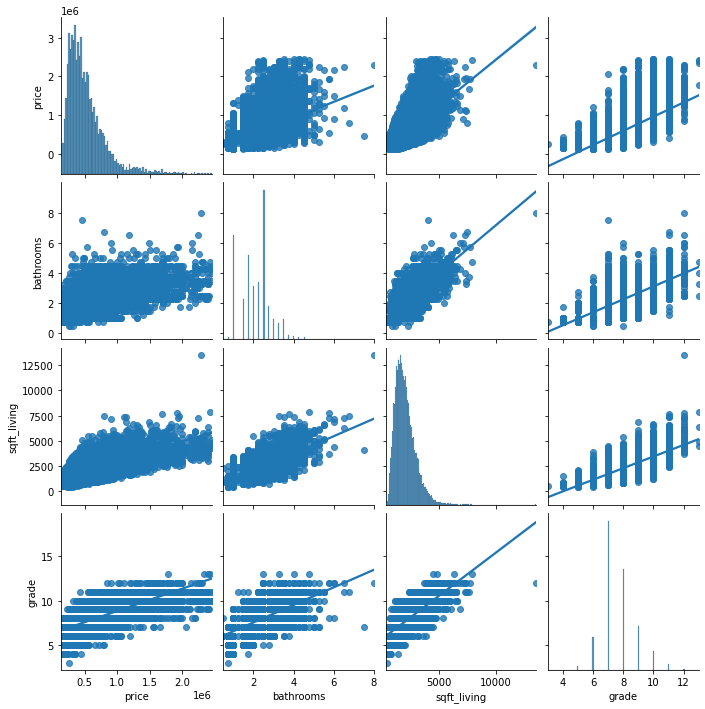

In [16]:
attributes = ['price', 'bathrooms', 'sqft_living', 'grade']

sns.pairplot(x_vars = attributes, y_vars = attributes, data = pop_data, kind='reg')
plt.show()

In [11]:
pop_data = pop_data[(pop_data.price < pop_data.price.quantile(.995)) & (pop_data.price > pop_data.price.quantile(.005))]

In [20]:
X = pop_data.drop(['price', 'city', 'season'], axis = 1).copy()
y = pop_data['price'].copy()

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [22]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sc = MinMaxScaler()
sc.fit(X_train)
X_train_scaled = pd.DataFrame(sc.transform(X_train), columns = X_train.columns, index = X_train.index)
X_test_scaled = pd.DataFrame(sc.transform(X_test), columns = X_test.columns, index = X_test.index)

In [29]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from pandas.api.types import is_numeric_dtype

lr = LinearRegression()

In [30]:
def train_test_compare(X_tr, X_te, y_tr, y_te):
    lr.fit(X_tr, y_tr)
    
    train_score = lr.score(X_tr, y_tr)
    test_score = lr.score(X_te, y_te)
    
    y_hat_train = lr.predict(X_tr)
    y_hat_test = lr.predict(X_te)
    
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_hat_train))
    test_rmse = np.sqrt(mean_squared_error(y_te, y_hat_test))
    
    print(f'Training data R2: {train_score}\nTesting data R2: {test_score}\nTraining data RMSE: {train_rmse}\nTesting data RMSE: {test_rmse}')

In [31]:
train_test_compare(X_train_scaled, X_test_scaled, y_train, y_test)

Training data R2: 0.7496499277765132
Testing data R2: 0.7501500830888133
Training data RMSE: 153494.3786228597
Testing data RMSE: 156005.35981798184


In [ ]:
non_luxury_data = pop_data.loc[(pop_data.price < 1_000_000)]

In [ ]:
non_luxury_data.plot(kind='scatter', x='long', y='lat', figsize=(15, 12), alpha=0.4, 
                     s=non_luxury_data['population']/10000, label='population', c='price', 
                     cmap=plt.get_cmap('jet'), colorbar=True)
plt.show()

In [ ]:
less_than_million = clean_data.loc[(clean_data.price < 1_000_000)]
million_house = clean_data.loc[(clean_data.price >= 1_000_000)]

In [ ]:
# import libraries
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
# import street map
street_map = gpd.read_file('Map/Incorporated_Areas_of_King_County___city_area.shp')

In [ ]:
less_geometry = [Point(xy) for xy in zip(less_than_million['long'], less_than_million['lat'])]

less_df = gpd.GeoDataFrame(less_than_million, crs = 'EPSG:4326', geometry = less_geometry)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))

street_map.plot(ax=ax, alpha=0.4,color='grey')

less_df.plot(column='price',ax=ax,alpha=0.5, legend=True, markersize=10, cmap='Spectral')

plt.title('House Prices in KingCounty', fontsize=15,fontweight='bold')

plt.xlim(clean_data.long.min(), clean_data.long.max())
plt.ylim(clean_data.lat.min(), clean_data.lat.max())

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))

street_map.plot(ax=ax, alpha=0.4,color='grey')

non_luxury_data.plot(kind='scatter', x='long', y='lat', alpha=0.4, ax=ax,
                     s=non_luxury_data['population']/10000, label='population', c='price', 
                     cmap=plt.get_cmap('jet'), colorbar=True)

plt.title('House Prices in KingCounty', fontsize=15,fontweight='bold')

plt.xlim(clean_data.long.min(), clean_data.long.max())
plt.ylim(clean_data.lat.min(), clean_data.lat.max())

plt.legend()
plt.show()

In [ ]:
median_pop = pop_data.groupby('zipcode').agg('median').reset_index()
median_pop_million = median_pop.loc[median_pop.price < 1_000_000]

In [ ]:
import folium as folium

kc_geo = 'Map/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.geojson'

m = folium.Map(location=[47.484823, -122.112342], tiles="cartodbpositron", zoom_start=9.5)

folium.Choropleth(
    geo_data=kc_geo,
    data=less_than_million,
    columns=['zipcode', 'price'],
    key_on='feature.properties.ZIP',
    fill_color='GnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='House Sale Prices').add_to(m)

folium.LayerControl().add_to(m)

m

In [ ]:
model = sm.OLS(clean_data['price'], sm.add_constant(clean_data['total_rooms'])).fit()
model.summary()

In [ ]:
predictors = feature_data.drop('price', axis=1)

from sklearn.feature_selection import RFE

selector = RFE(lr, n_features_to_select=5)
selector = selector.fit(predictors, feature_data['price'])

In [ ]:
selector.support_ 

In [ ]:
selector.ranking_

In [ ]:
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

ranks = {}

def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [ ]:
y, X = get_y_X(feature_data, 'price')
columns = feature_data.columns

In [ ]:
# Construct our Linear Regression model
lr = LinearRegression(normalize=True)
lr.fit(X,y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose = 3)
rfe.fit(X,y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), columns, order=-1)

In [ ]:
lr = LinearRegression(normalize=True)
lr.fit(X,y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), columns)

In [ ]:
estimator = SVR(kernel="linear")
#Use RFE to remove not significant features from the initial model.
selector = RFE(estimator, step=1)
selector = selector.fit(X, y)
#Test new model
#New features dataframe containing only selected features through RFE
X_RFE = X[X.columns[selector.support_]]
lin_reg(X_RFE, y)

In [ ]:
# # Run linear regression on luxury houses
# luxury = dummy_data.loc[(dummy_data['price'] >= 1_000_000)]

# y, X = get_y_X(luxury, 'price')
# X_train, X_test, y_train, y_test = train_test(y, X)
# train_test_compare(X_train, X_test, y_train, y_test)

In [ ]:
# # Run linear regression on feature engineered data
# non_luxury = dummy_data.loc[(dummy_data['price'] < 1_000_000)]

# y, X = get_y_X(non_luxury, 'price')
# X_train, X_test, y_train, y_test = train_test(y, X)
# train_test_compare(X_train, X_test, y_train, y_test)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data.cylinders.values.reshape(-1,1))
scaler.transform(data.cylinders.values.reshape(-1,1))